In [242]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

In [243]:
df = pd.read_csv("Melbourne_housing_FULL.csv")
df.tail()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
34852,Yarraville,13 Burns St,4,h,1480000.0,PI,Jas,24/02/2018,6.3,3013.0,...,1.0,3.0,593.0,NaN,NaN,Maribyrnong City Council,-37.81053,144.88467,Western Metropolitan,6543.0
34853,Yarraville,29A Murray St,2,h,888000.0,SP,Sweeney,24/02/2018,6.3,3013.0,...,2.0,1.0,98.0,104.0,2018.0,Maribyrnong City Council,-37.81551,144.88826,Western Metropolitan,6543.0
34854,Yarraville,147A Severn St,2,t,705000.0,S,Jas,24/02/2018,6.3,3013.0,...,1.0,2.0,220.0,120.0,2000.0,Maribyrnong City Council,-37.82286,144.87856,Western Metropolitan,6543.0
34855,Yarraville,12/37 Stephen St,3,h,1140000.0,SP,hockingstuart,24/02/2018,6.3,3013.0,...,NaN,NaN,NaN,NaN,NaN,Maribyrnong City Council,NaN,NaN,Western Metropolitan,6543.0
34856,Yarraville,3 Tarrengower St,2,h,1020000.0,PI,RW,24/02/2018,6.3,3013.0,...,1.0,0.0,250.0,103.0,1930.0,Maribyrnong City Council,-37.81810,144.89351,Western Metropolitan,6543.0


In [244]:
## Create another column for the age of the house. 
df['Age_of_Building'] = 2018 - df['YearBuilt']

In [245]:
## Create another column for price in thousands.
df['New_Price'] = df['Price']/1000

In [246]:
## Looking how much null we have all together on each columns.
df.isnull().sum()

Suburb                 0
Address                0
Rooms                  0
Type                   0
Price               7610
Method                 0
SellerG                0
Date                   0
Distance               1
Postcode               1
Bedroom2            8217
Bathroom            8226
Car                 8728
Landsize           11810
BuildingArea       21115
YearBuilt          19306
CouncilArea            3
Lattitude           7976
Longtitude          7976
Regionname             3
Propertycount          3
Age_of_Building    19306
New_Price           7610
dtype: int64

In [247]:
df.head(1)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Age_of_Building,New_Price
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,NaN,NaN


In [248]:
## We are separating the House from other Type of housing, such as Condo/Town House.
df['TypeH'] = np.where(df['Type'] == 'h', 1, 0) ## Great than 0 = 1, else 0

In [249]:
## Since we have a lot of data, we using dropna to drop all missing datas on this dataset. 
df.dropna(inplace=True)

In [250]:
## Now we do not see any more null in our dataset. 
df.isnull().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2           0
Bathroom           0
Car                0
Landsize           0
BuildingArea       0
YearBuilt          0
CouncilArea        0
Lattitude          0
Longtitude         0
Regionname         0
Propertycount      0
Age_of_Building    0
New_Price          0
TypeH              0
dtype: int64

In [251]:
## We are selecting only parameters that have an effect on our outcomes, dropping any categorical and unimportant parameters.
new_df = df[['Rooms', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Lattitude', 'Longtitude', 'Propertycount', 'Age_of_Building', 'TypeH', 'New_Price']]

In [252]:
## Show the head of all the columns that we are going to work with.
new_df.tail(10)

,Rooms,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Age_of_Building,TypeH,New_Price
34826,4,6.4,3012.0,1.0,1.0,219.0,113.0,-37.79761,144.88053,5058.0,108.0,1,832.0
34828,3,6.4,3012.0,1.0,2.0,460.0,112.0,-37.80139,144.86458,5058.0,78.0,1,900.0
34831,4,16.5,3049.0,2.0,5.0,560.0,148.0,-37.68089,144.87403,2474.0,38.0,1,675.0
34836,5,16.7,3150.0,2.0,2.0,739.0,293.0,-37.89304,145.18475,7392.0,38.0,1,1400.0
34837,5,6.8,3016.0,3.0,2.0,450.0,241.0,-37.86180,144.87855,6380.0,3.0,1,2020.0
34847,3,25.5,3750.0,2.0,2.0,383.0,118.0,-37.61940,145.03951,2940.0,2.0,1,500.0
34849,3,25.5,3750.0,2.0,2.0,404.0,158.0,-37.61031,145.03393,2940.0,6.0,1,570.0
34853,2,6.3,3013.0,2.0,1.0,98.0,104.0,-37.81551,144.88826,6543.0,0.0,1,888.0
34854,2,6.3,3013.0,1.0,2.0,220.0,120.0,-37.82286,144.87856,6543.0,18.0,0,705.0
34856,2,6.3,3013.0,1.0,0.0,250.0,103.0,-37.81810,144.89351,6543.0,88.0,1,1020.0


In [253]:
## The median of all the parameters that we are going to work with.
new_df.median()

Rooms                 3.0000
Distance             10.2000
Postcode           3084.0000
Bathroom              2.0000
Car                   2.0000
Landsize            478.0000
BuildingArea        132.0000
Lattitude           -37.7987
Longtitude          144.9985
Propertycount      6567.0000
Age_of_Building      48.0000
TypeH                 1.0000
New_Price           900.0000
dtype: float64

In [254]:
## More information of all the parameters we are working with.
new_df.describe()

,Rooms,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Age_of_Building,TypeH,New_Price
count,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,11.199887,3111.662653,1.646450,1.692247,523.480365,149.309477,-37.804501,144.991393,7475.940137,52.246652,0.745471,1092.901629
std,0.963786,6.813402,112.614268,0.721611,0.975464,1061.324228,87.925580,0.090549,0.118919,4375.024364,37.040876,0.435621,679.381904
min,1.000000,0.000000,3000.000000,1.000000,0.000000,0.000000,0.000000,-38.174360,144.423790,249.000000,-1.000000,0.000000,131.000000
25%,2.000000,6.400000,3044.000000,1.000000,1.000000,212.000000,100.000000,-37.858560,144.920000,4382.500000,18.000000,0.000000,641.000000
50%,3.000000,10.200000,3084.000000,2.000000,2.000000,478.000000,132.000000,-37.798700,144.998500,6567.000000,48.000000,1.000000,900.000000
75%,4.000000,13.900000,3150.000000,2.000000,2.000000,652.000000,180.000000,-37.748945,145.064560,10331.000000,73.000000,1.000000,1345.000000
max,12.000000,47.400000,3977.000000,9.000000,10.000000,42800.000000,3112.000000,-37.407200,145.526350,21650.000000,822.000000,1.000000,9000.000000


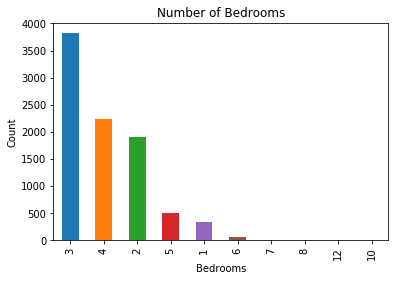

In [255]:
#Determine the most popular number of bedrooms.
new_df['Rooms'].value_counts().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

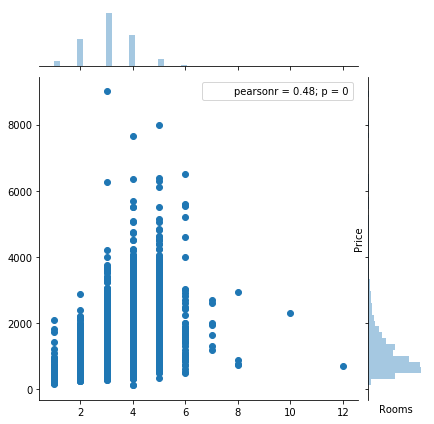

<function seaborn.utils.despine>

In [256]:
## Checking to see price against rooms of the houses. Most attractive is houses with 3-5 rooms. 
## Of course, bigger houses mean it going to be a bit more expensive, and should have more rooms in it. 
## This is comparing within the same area code. Not that bigger house mean it will be more expensive. Location is very important.
plt.figure(figsize=(5,5))
sns.jointplot(x=new_df.Rooms.values, y=new_df.New_Price.values)
plt.ylabel('Price')
plt.xlabel('Rooms')
plt.show()
sns.despine

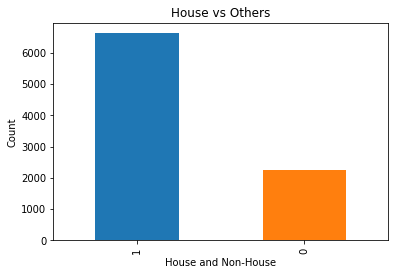

In [257]:
## Checking to see if people buy houses more than condo/town house etc...
new_df['TypeH'].value_counts().plot(kind='bar')
plt.title('House vs Others')
plt.xlabel('House and Non-House')
plt.ylabel('Count')
plt.show()
#People are more likely to buy houses than Condo/Townhouse.

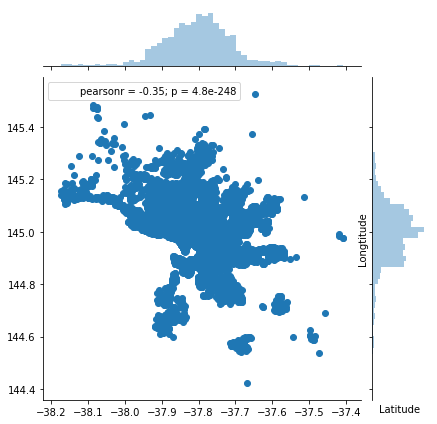

<function seaborn.utils.despine>

In [258]:
#Determine popular locations based on location.
plt.figure(figsize=(5,5))
sns.jointplot(x=new_df.Lattitude.values, y=new_df.Longtitude.values)
plt.ylabel('Longtitude')
plt.xlabel('Latitude')
plt.show()
sns.despine
#Latitude @ -38.5 to -37.7 and longtitude 144.9-145.1 show the highest concentration of data. 
#Likely the most popular areas for home sales.

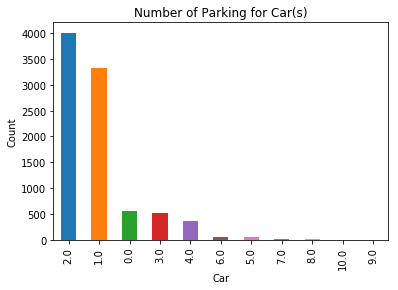

In [259]:
## More houses that are being sold have 2 Carspots for parking. 
new_df['Car'].value_counts().plot(kind='bar')
plt.title('Number of Parking for Car(s)')
plt.xlabel('Car')
plt.ylabel('Count')
plt.show()

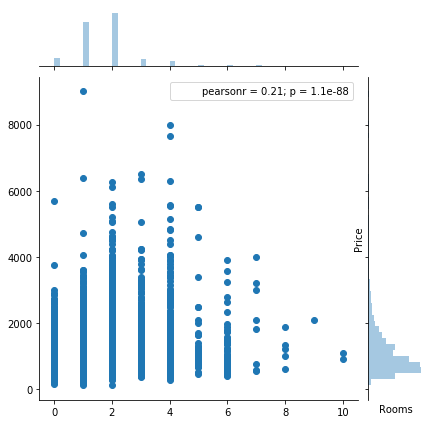

<function seaborn.utils.despine>

In [260]:
## People who buy houses will likely to pay higher for houses that have 2-4 parkings spot available.
plt.figure(figsize=(5,5))
sns.jointplot(x=new_df.Car.values, y=new_df.New_Price.values)
plt.ylabel('Price')
plt.xlabel('Rooms')
plt.show()
sns.despine

(0, 4000)

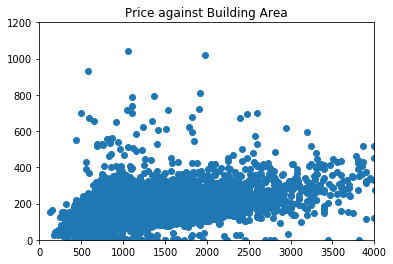

In [261]:
plt.scatter(new_df.New_Price,new_df.BuildingArea)
plt.title('Price against Building Area')
plt.ylim([0,1200])
plt.xlim([0,4000])
## Buyers tend to buy houses that have building size around 200-230 meters.

(0, 5000)

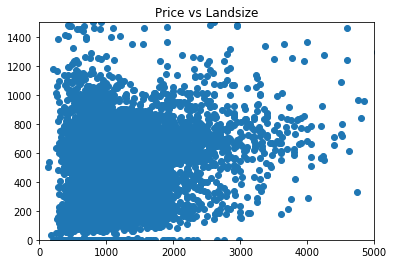

In [262]:
plt.scatter(new_df.New_Price,new_df.Landsize)
plt.title('Price vs Landsize')
plt.ylim([0,1500])
plt.xlim([0, 5000])
## Buyers tend to buy houses that have landsize around 700 meters.

(0, 5000)

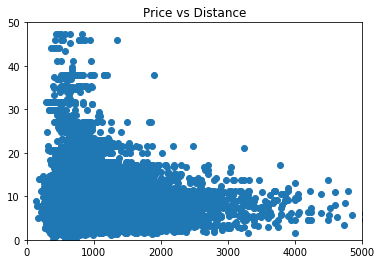

In [263]:
## Price against distance from CBD in Kilometers.
plt.scatter(new_df.New_Price,new_df.Distance)
plt.title('Price vs Distance')
plt.ylim([0,50])
plt.xlim([0, 5000])
# Distance around 10 is the optimal.

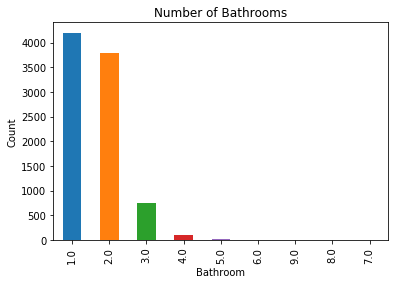

In [264]:
## More buyers are buying houses that have 1 bathrooms.
new_df['Bathroom'].value_counts().plot(kind='bar')
plt.title('Number of Bathrooms')
plt.xlabel('Bathroom')
plt.ylabel('Count')
plt.show()

Text(0.5,1,'Bathrooms against Price in Thousands')

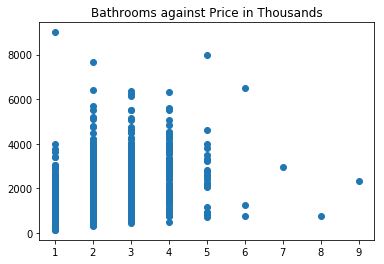

In [265]:
plt.scatter(new_df.Bathroom,new_df.New_Price)
plt.title('Bathrooms against Price in Thousands')
#Able to fetch higher prices with 2-4 bathrooms.

Text(0.5,1,'Pricey Locations by Zipcodes')

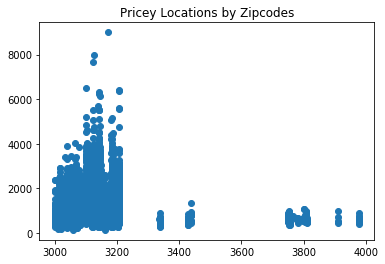

In [266]:
## Buyers tend to buy houses around 3000-3200 area code. 
plt.scatter(new_df.Postcode,new_df.New_Price)
plt.title('Pricey Locations by Zipcodes')

(0, 200)

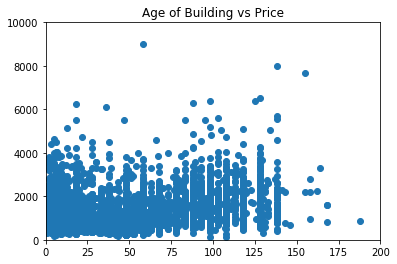

In [267]:
plt.scatter(new_df.Age_of_Building,new_df.New_Price)
plt.title('Age of Building vs Price')
plt.ylim([0,10000])
plt.xlim([0, 200])
# More houses are being sold if it newer. But older houses does not lose it value. 

(0, 17500)

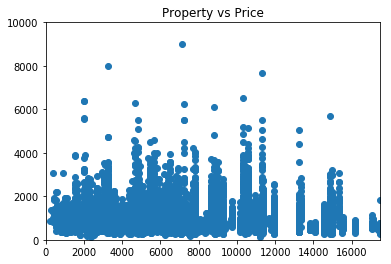

In [268]:
## Buyers are interested in property that located around 4500 to 8000. 
plt.scatter(new_df.Propertycount,new_df.New_Price)
plt.title('Property vs Price')
plt.ylim([0,10000])
plt.xlim([0, 17500])

In [269]:
## Logging to help us view data more comfortably and to make a better decision. 

C:\Users\cvo.MODIFIEDPOLYMER\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


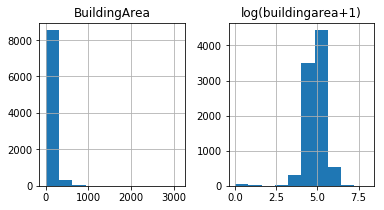

In [270]:
#Log the building area variable#Log the b 
plt.rcParams['figure.figsize'] = (6.0, 3.0)
buildingarea = pd.DataFrame({"BuildingArea":new_df["BuildingArea"], "log(buildingarea+1)":np.log1p(new_df["BuildingArea"])})
buildingarea.hist(bins = 10)
new_df['BuildingArea'] = np.log1p(new_df["BuildingArea"])
## it is less skewed, and we can have a better decision on what to do next. Such as increase the building area. 

C:\Users\cvo.MODIFIEDPOLYMER\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


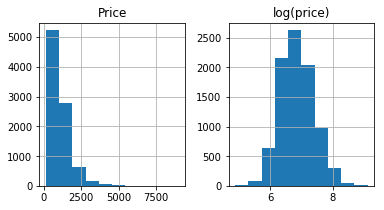

In [271]:
#Log the price variable
plt.rcParams['figure.figsize'] = (6.0, 3.0)
price = pd.DataFrame({"Price":new_df["New_Price"], "log(price)":np.log1p(new_df["New_Price"])})
price.hist(bins = 10)
new_df['New_Price'] = np.log1p(new_df["New_Price"])
## much less skewed than before.

C:\Users\cvo.MODIFIEDPOLYMER\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


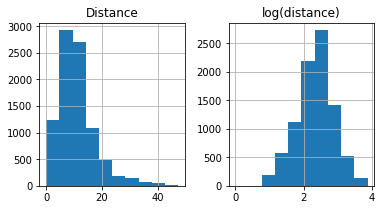

In [272]:
#Log the distance variable.
plt.rcParams['figure.figsize'] = (6.0, 3.0)
price = pd.DataFrame({"Distance":new_df["Distance"], "log(distance)":np.log1p(new_df["Distance"])})
price.hist(bins = 10)
new_df['Distance'] = np.log1p(new_df["Distance"])
## Less skewed.

In [273]:
# Create our feature and target training and test set
X = new_df.drop(['New_Price'], 1)
y = new_df['New_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [274]:
print (X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6220, 12) (6220,)
(2667, 12) (2667,)


In [275]:
lm = linear_model.LinearRegression()

In [276]:
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [277]:
print(predictions)

[6.46186384 6.23736096 6.41467353 ... 6.34914107 6.08604429 7.48118885]


Text(0,0.5,'Predictions')

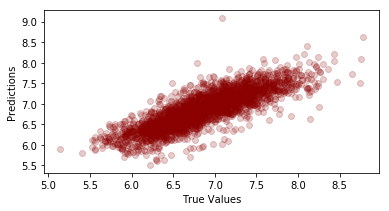

In [278]:
plt.scatter(y_test, predictions, color='darkred', alpha=.2)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [279]:
print ("Score:"), model.score(X_test, y_test)

Score:


(None, 0.6864976837385044)

In [280]:
## KNN Regression

In [281]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
score = cross_val_score(knn, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.51 (+/- 0.13)


In [282]:
## With KNN, the unweighted give us 51% accuracy rate and with Weighted, it give us 56% accuracy rate.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=6, weights='distance')
knn_w.fit(X,y)
score_w = cross_val_score(knn_w, X, y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Weighted Accuracy: 0.56 (+/- 0.14)


In [283]:
## Linear Regression

In [284]:
## Linear Regression give us 68% accuracy rate.
regr = LinearRegression()
regr.fit(X_train, y_train)
y_predict = regr.predict(X_test)
print( f'r-squared: {r2_score(y_test, y_predict)}')

r-squared: 0.672707706830073


In [285]:
## OLS

In [286]:
import statsmodels.formula.api as smf
linear_formula = 'New_Price~Rooms+Car+Distance+TypeH+Bathroom+BuildingArea+Age_of_Building+Landsize+Longtitude+Lattitude+Propertycount'
lm = smf.ols(formula=linear_formula, data=new_df).fit()

In [317]:
##dropped Postcode since it does not affect us rather we have it or not. 

In [288]:
## OLS gave us 68% accuracy rate.
lm.rsquared

0.690859459792543

In [289]:
## Support Vector Regression

In [312]:
svr = SVR()
svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

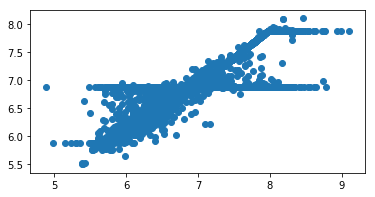

In [313]:
plt.scatter(y, svr.predict(X))

In [316]:
## SVR have a very low accuracy rate. 
svr.score(X_test, y_test)

0.1705872956379476

In [294]:
cross_val_score(svr, X, Y, cv=5)

array([-0.1991053 , -0.03855368, -0.04870784, -0.04061897, -0.13455723])

In [295]:
predicted = svr.predict(X)
print(predicted)

[900.4008324  900.34993936 900.49692579 ... 898.34986037 898.34640351
 900.34986037]


In [296]:
## Ridge Regression

In [297]:
from sklearn.linear_model import Ridge

In [300]:
reg = Ridge()

reg.fit(X_train, y_train)
y_predict = reg.predict(X_test)
print( f'r-squared: {r2_score(y_test, y_predict)}')

r-squared: 0.6725768807612671


In [301]:
reg.coef_

array([ 1.46384303e-01, -4.04490146e-01,  8.05877266e-05,  1.42032875e-01,
        4.73892021e-02,  2.01817192e-05,  1.60693097e-01, -1.01236232e+00,
        9.03063510e-01, -5.24664528e-06,  2.69096104e-03,  2.88403037e-01])

In [302]:
## Lasso Regression

In [303]:
lasso = Lasso()

lasso.fit(X_train, y_train)
y_predict = lasso.predict(X_test)
print( f'r-squared: {r2_score(y_test, y_predict)}')

r-squared: 0.1422891108985046


In [304]:
## Random Forest Regression

In [305]:
rfr = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_depth=20) 
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print(rfr.get_params)
print()
print( f'r-squared: {r2_score(y_test, y_predict)}')

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

r-squared: 0.8744774605450983


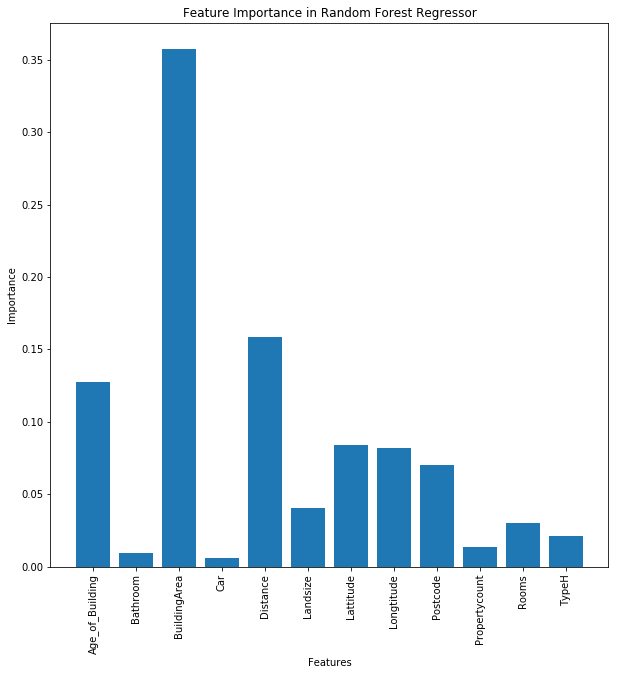

In [306]:
plt.figure(figsize=(10,10))
plt.bar(X.columns[0:15], rfr.feature_importances_[0:15])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

In [307]:
## Gradient Boosted Regression

In [308]:
gbr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, max_depth=5)
gbr.fit(X_train, y_train)
y_predict = gbr.predict(X_test)
print(gbr.get_params)
print()
print( f'r-squared: {r2_score(y_test, y_predict)}')

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)>

r-squared: 0.8827365349826835


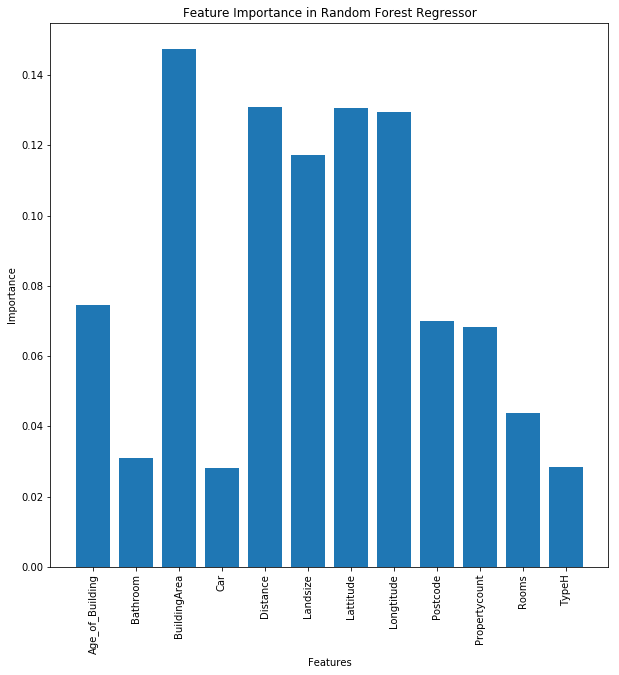

In [309]:
plt.figure(figsize=(10,10))
plt.bar(X.columns[0:15], gbr.feature_importances_[0:15])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

The highest model that performed well for houses is Gradient Boosted, follow by random forest, that scored 88% and 87% respectively. OLS:69, Linear Regression:67 and Ridge:67 are the third, fourth, and fifth respectively. When buyers are looking to buy houses, they looking at how big is the area of the building is, the size of the land, the distance to CBD and the location of the house. These four are the main value that make a house valueable in the market place. 